# Baseline Model for Twitter Sentiment Analysis

This model will use Multinomial Naive Bayes with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

It will implement SMOTE to synthesize additional data to balance the classes.

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import evaluation_functions
from sklearn.feature_extraction.text import TfidfTransformer 
from imblearn.over_sampling import SMOTE
import ast

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
DATA_FILE_PATH = 'data/crowdflower-brands-and-product-emotions/data/'
TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [3]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [4]:
df.head()

tweet_text  \
0             i have a g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw   
1   know about   awesome ipad/iphone app that you'll likely appreciate for its design also they're giving free ts at #sxsw   
2                                                         can not wait for #ipad  also they should sale them down at #sxsw   
3                                              i hope this year's festival isn't as crashy as this year's iphone app #sxsw   
4       great stuff on fri #sxsw: marissa mayer (google) tim o'reilly (tech books/conferences)  matt mullenweg (wordpress)   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  \
0                                   Negative emotion   
1                                   Positive emotion   
2                                   Positive emotion   
3                                   Negative emotion   
4                                   Positive emotion   

                                                                                                                                                                              tokens  
0         ['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']  
1  ['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', "you'll", 'likely', 'appreciate', 'for', 'its', 'design', 'also', "they're", 'giving', 'free', 'ts', 'at', '#sxsw']  
2                                                                            ['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']  
3                                                             ['i', 'hope', 'this', "year's", 'festival', "isn't", 'as', 'crashy', 'as', 'this', "year's", 'iphone', 'app', '#sxsw']  
4                        ['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', "o'reilly", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']

In [5]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [6]:
data = df[['tokens', 'is_there_an_emotion_directed_at_a_brand_or_product']]

In [7]:
data.head()

tokens  \
0           [i, have, a, g, iphone, after, hrs, tweeting, at, #riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, #sxsw]   
1  [know, about, awesome, ipad, iphone, app, that, you'll, likely, appreciate, for, its, design, also, they're, giving, free, ts, at, #sxsw]   
2                                                              [can, not, wait, for, #ipad, also, they, should, sale, them, down, at, #sxsw]   
3                                                 [i, hope, this, year's, festival, isn't, as, crashy, as, this, year's, iphone, app, #sxsw]   
4                [great, stuff, on, fri, #sxsw, marissa, mayer, google, tim, o'reilly, tech, books, conferences, matt, mullenweg, wordpress]   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

# Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [9]:
X_train.shape

(6855,)

In [10]:
X_test.shape

(1714,)

# Encode Labels

In [11]:
le = LabelEncoder()

In [12]:
y_train_enc = le.fit_transform(y_train)

In [13]:
y_test_enc = le.transform(y_test)

# Evaluate Adjustments to Minimum Document Frequency

In [14]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [15]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([
                        ('bow',CountVectorizer(min_df=min_df,
                                               preprocessor=passthrough, 
                                               tokenizer=passthrough)),  
                        ('tfidf', TfidfTransformer()),
                        ('smote', SMOTE(random_state=RANDOM_STATE, 
                                        n_jobs=-1)),
                        ('classifier', MultinomialNB())])
    
    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_train, 
                                                                 y_train_enc, 
                                                                 le.classes_, 
                                                                 'Training')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_test, 
                                                                 y_test_enc, 
                                                                 le.classes_,
                                                                 'Test')
    
    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test_multi = lb.transform(y_test_enc)
    y_hat_test_multi = pipeline.predict_proba(X_test)
    
    evaluation_functions.pr_curves(y_test_multi, y_hat_test_multi, le.classes_)
    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
        
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy]),
                             recall_scores)
   
    return test_results
    

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 1

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.47      0.97      0.64       436
No emotion toward brand or product       0.92      0.71      0.81      4124
                  Positive emotion       0.70      0.84      0.76      2295

                          accuracy                           0.77      6855
                         macro avg       0.70      0.84      0.73      6855
                      weighted avg       0.82      0.77      0.78      6855



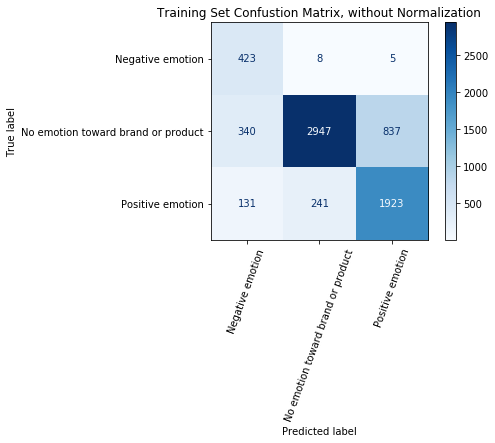

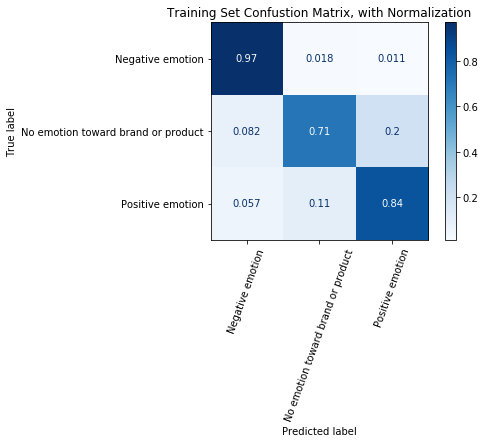

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.60      0.36       109
No emotion toward brand or product       0.79      0.56      0.65      1031
                  Positive emotion       0.52      0.66      0.58       574

                          accuracy                           0.60      1714
                         macro avg       0.52      0.61      0.53      1714
                      weighted avg       0.67      0.60      0.61      1714



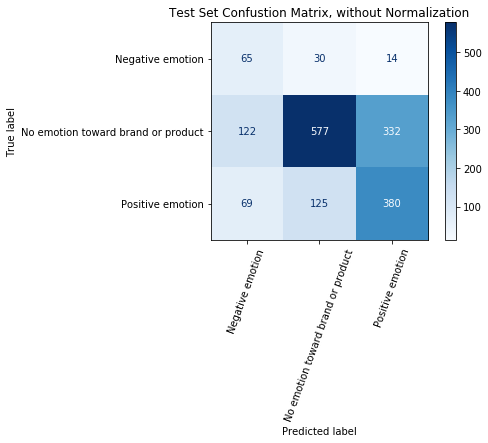

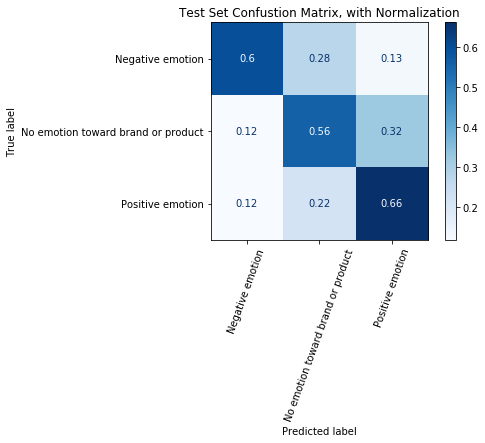

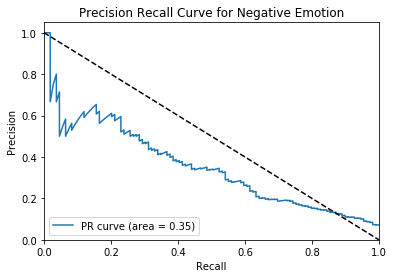

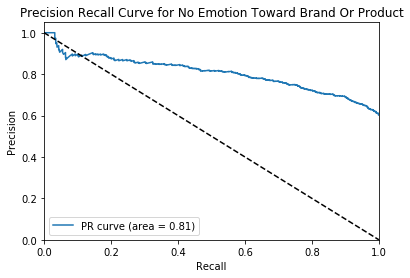

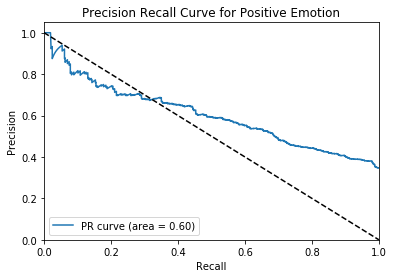

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 2

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.41      0.94      0.57       436
No emotion toward brand or product       0.90      0.68      0.78      4124
                  Positive emotion       0.67      0.80      0.73      2295

                          accuracy                           0.74      6855
                         macro avg       0.66      0.81      0.69      6855
                      weighted avg       0.79      0.74      0.75      6855



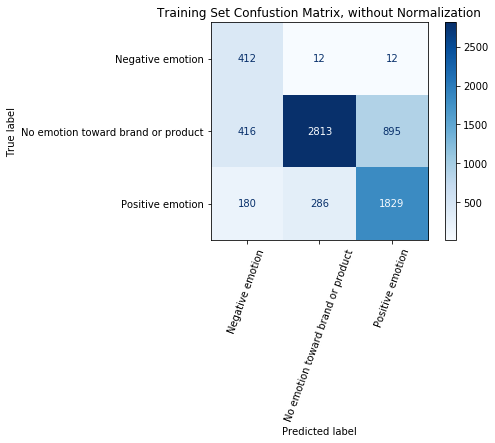

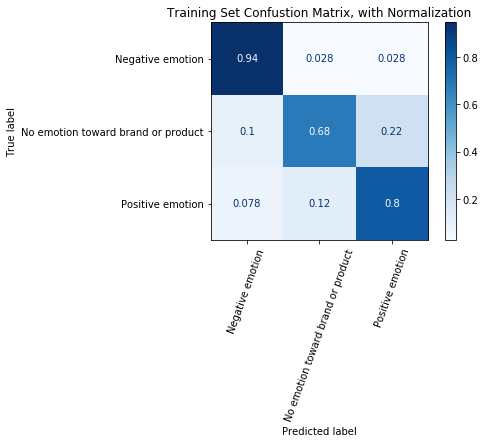

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.60      0.34       109
No emotion toward brand or product       0.79      0.55      0.65      1031
                  Positive emotion       0.52      0.66      0.58       574

                          accuracy                           0.59      1714
                         macro avg       0.52      0.60      0.53      1714
                      weighted avg       0.67      0.59      0.61      1714



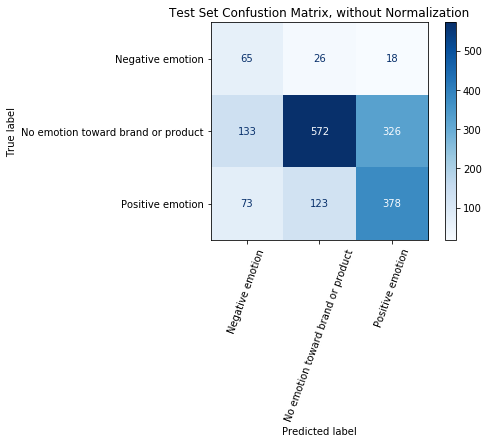

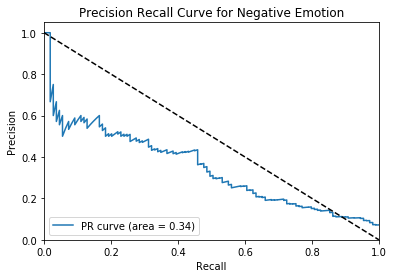

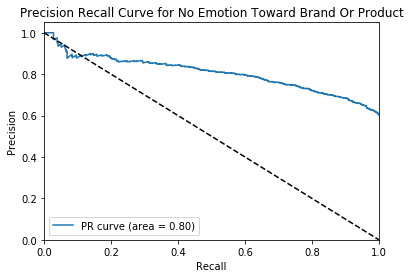

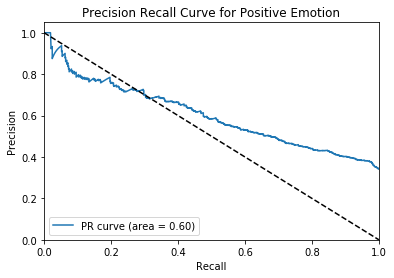

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 3

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.37      0.93      0.53       436
No emotion toward brand or product       0.88      0.67      0.76      4124
                  Positive emotion       0.65      0.76      0.70      2295

                          accuracy                           0.71      6855
                         macro avg       0.64      0.78      0.67      6855
                      weighted avg       0.77      0.71      0.73      6855



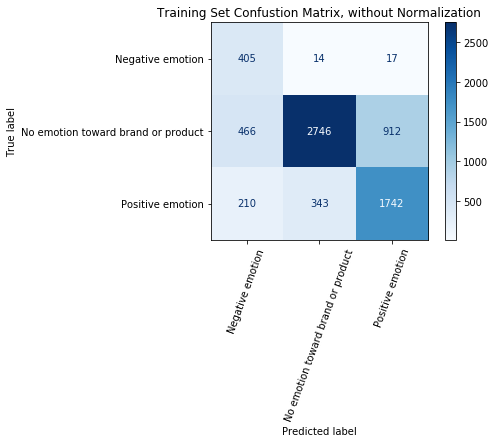

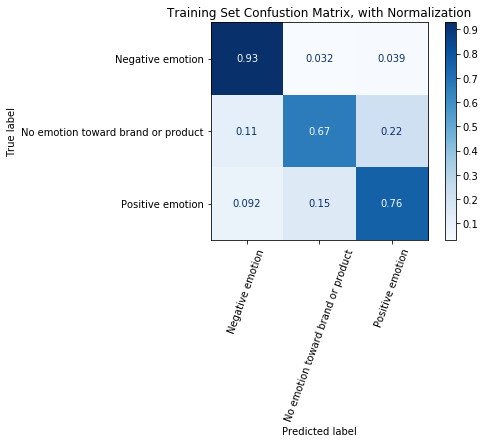

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.60      0.34       109
No emotion toward brand or product       0.79      0.56      0.65      1031
                  Positive emotion       0.52      0.64      0.57       574

                          accuracy                           0.59      1714
                         macro avg       0.51      0.60      0.52      1714
                      weighted avg       0.66      0.59      0.61      1714



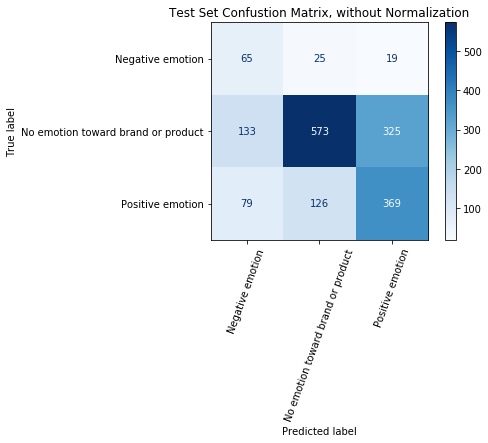

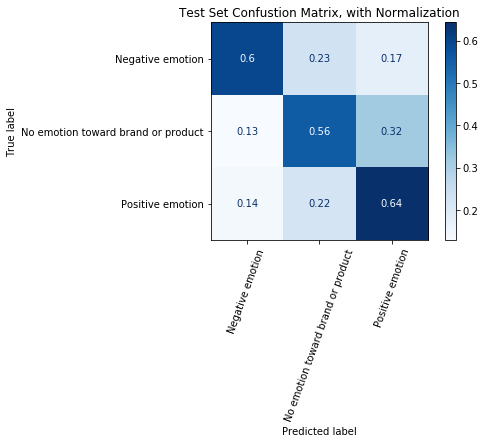

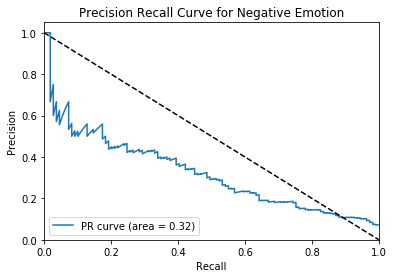

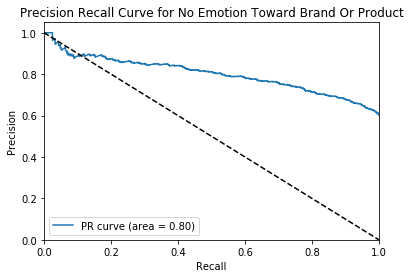

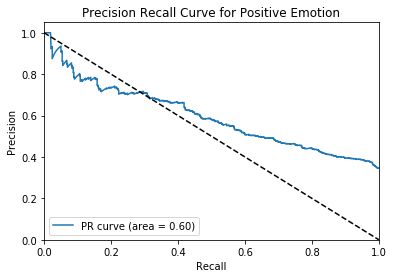

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 4

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.35      0.91      0.51       436
No emotion toward brand or product       0.87      0.65      0.74      4124
                  Positive emotion       0.63      0.74      0.68      2295

                          accuracy                           0.69      6855
                         macro avg       0.62      0.76      0.64      6855
                      weighted avg       0.76      0.69      0.71      6855



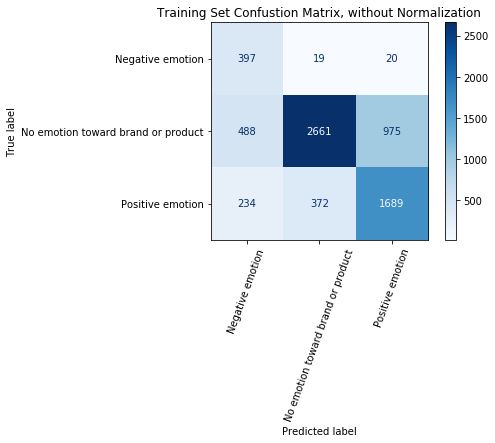

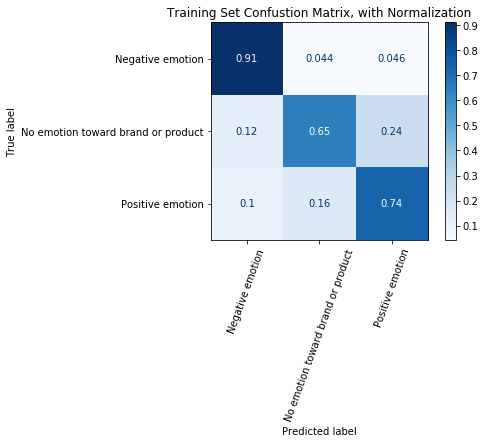

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.60      0.33       109
No emotion toward brand or product       0.79      0.55      0.65      1031
                  Positive emotion       0.52      0.64      0.57       574

                          accuracy                           0.58      1714
                         macro avg       0.51      0.59      0.52      1714
                      weighted avg       0.66      0.58      0.60      1714



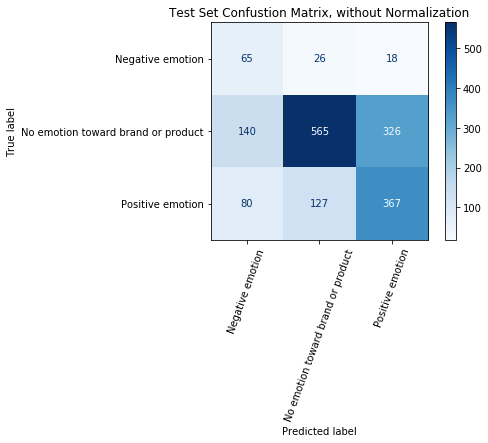

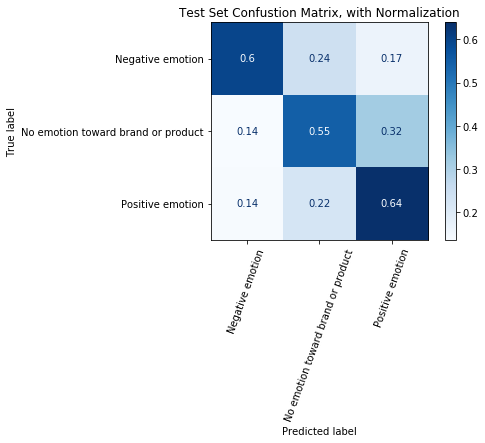

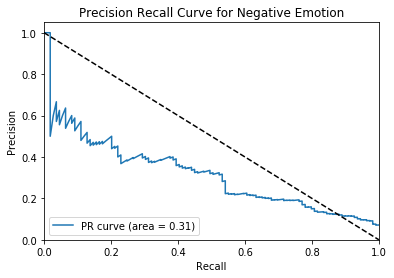

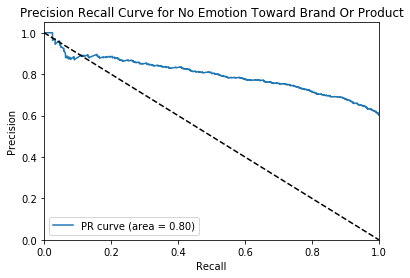

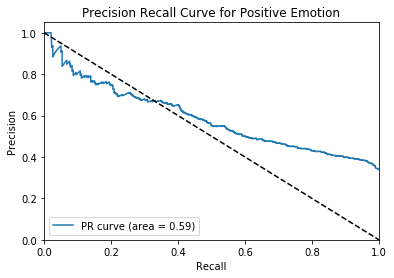

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 5

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.35      0.90      0.50       436
No emotion toward brand or product       0.87      0.64      0.73      4124
                  Positive emotion       0.62      0.73      0.67      2295

                          accuracy                           0.68      6855
                         macro avg       0.61      0.75      0.63      6855
                      weighted avg       0.75      0.68      0.70      6855



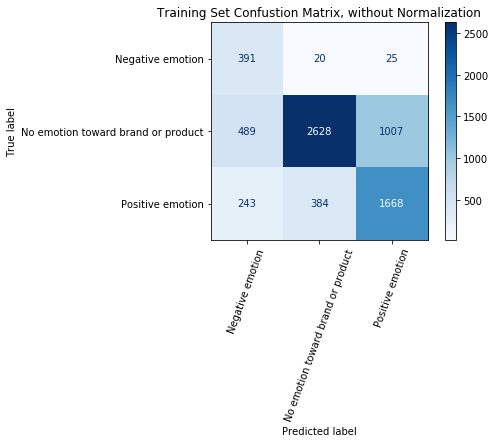

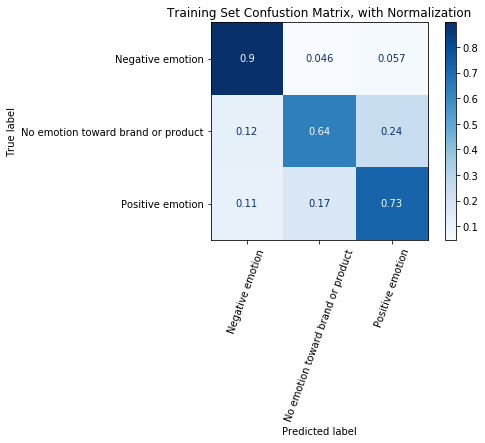

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.60      0.34       109
No emotion toward brand or product       0.79      0.56      0.65      1031
                  Positive emotion       0.52      0.64      0.58       574

                          accuracy                           0.59      1714
                         macro avg       0.52      0.60      0.52      1714
                      weighted avg       0.67      0.59      0.61      1714



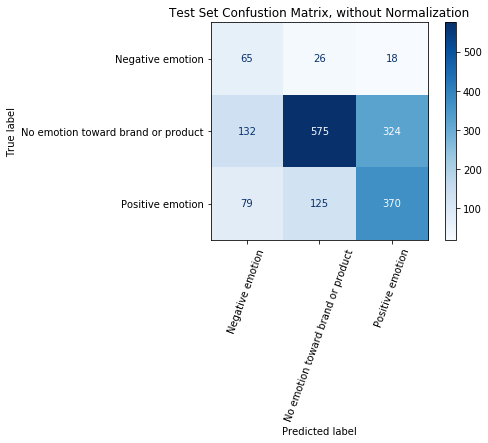

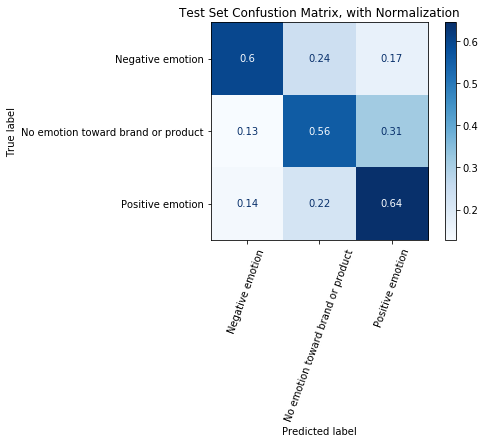

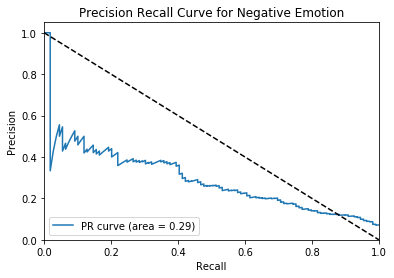

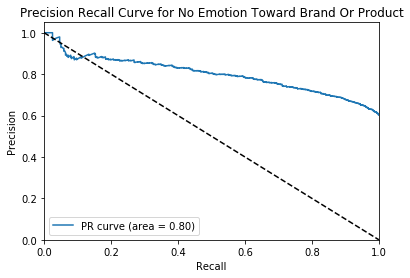

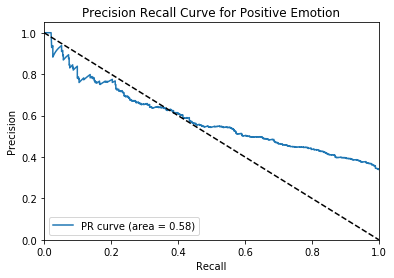

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 6

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.34      0.89      0.49       436
No emotion toward brand or product       0.86      0.63      0.73      4124
                  Positive emotion       0.61      0.71      0.66      2295

                          accuracy                           0.67      6855
                         macro avg       0.60      0.74      0.62      6855
                      weighted avg       0.74      0.67      0.69      6855



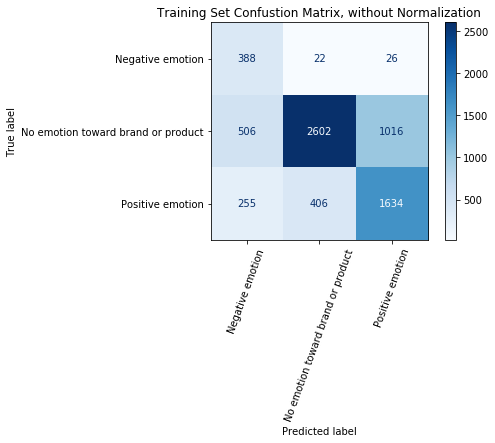

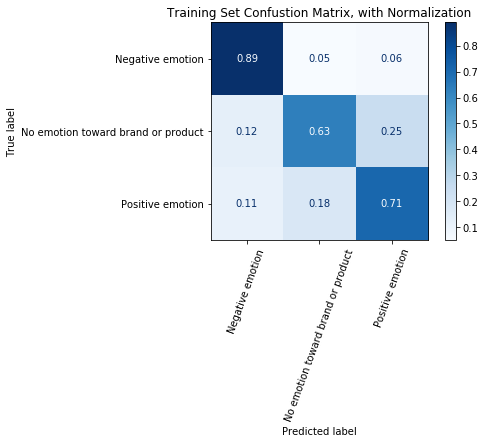

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.60      0.33       109
No emotion toward brand or product       0.79      0.54      0.64      1031
                  Positive emotion       0.50      0.63      0.56       574

                          accuracy                           0.57      1714
                         macro avg       0.50      0.59      0.51      1714
                      weighted avg       0.66      0.57      0.59      1714



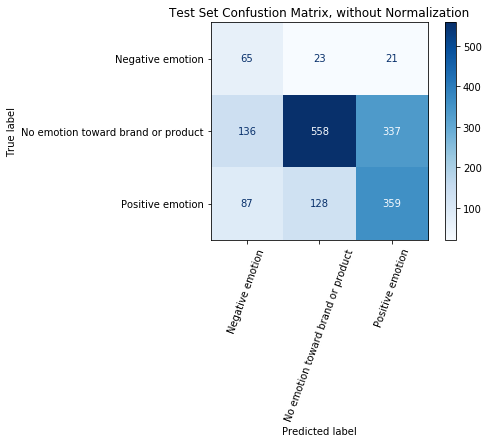

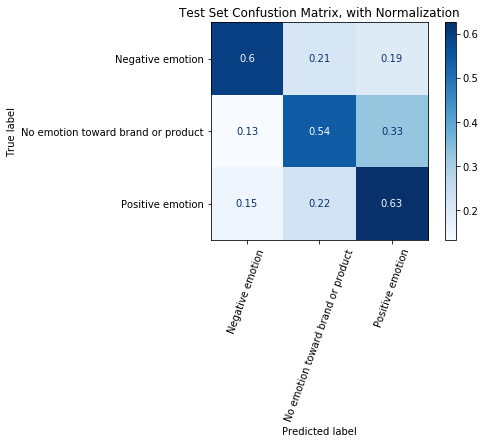

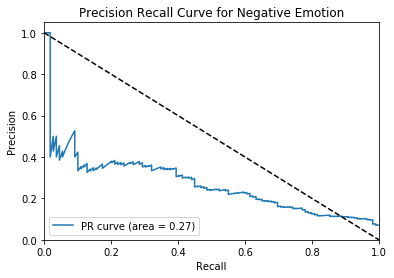

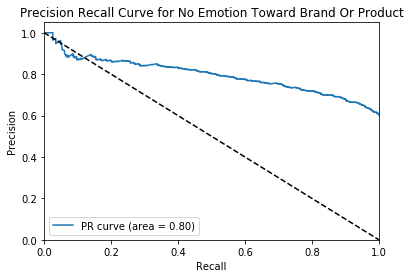

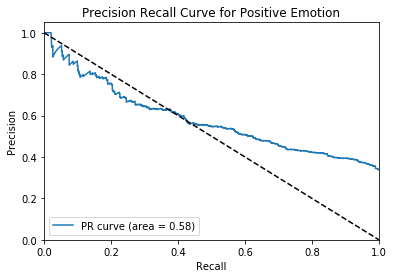

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 7

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.32      0.88      0.47       436
No emotion toward brand or product       0.85      0.62      0.72      4124
                  Positive emotion       0.60      0.69      0.65      2295

                          accuracy                           0.66      6855
                         macro avg       0.59      0.73      0.61      6855
                      weighted avg       0.73      0.66      0.68      6855



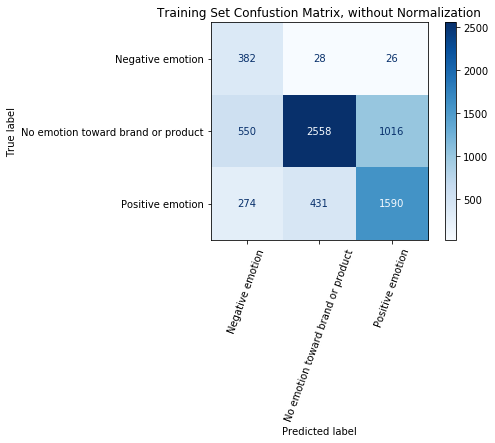

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.62      0.33       109
No emotion toward brand or product       0.79      0.54      0.64      1031
                  Positive emotion       0.50      0.62      0.56       574

                          accuracy                           0.57      1714
                         macro avg       0.51      0.59      0.51      1714
                      weighted avg       0.66      0.57      0.59      1714



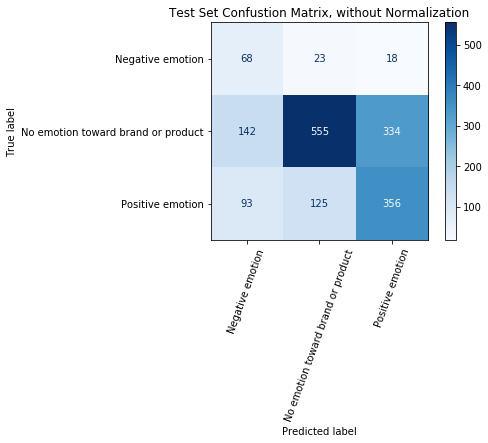

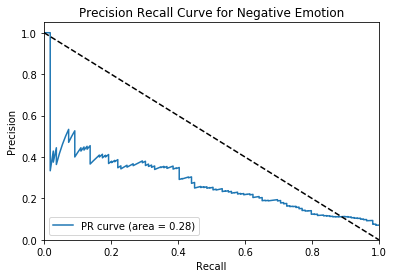

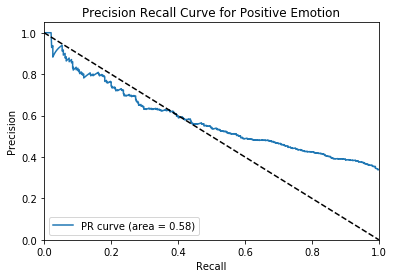

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 8

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.30      0.87      0.45       436
No emotion toward brand or product       0.84      0.61      0.71      4124
                  Positive emotion       0.60      0.68      0.63      2295

                          accuracy                           0.65      6855
                         macro avg       0.58      0.72      0.60      6855
                      weighted avg       0.73      0.65      0.67      6855



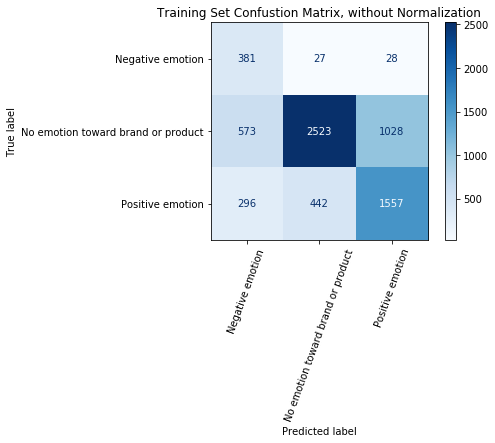

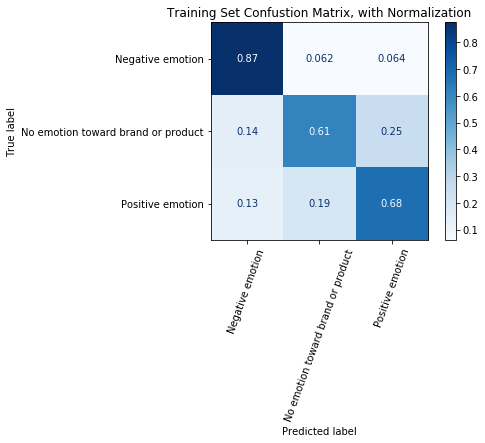

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.21      0.61      0.31       109
No emotion toward brand or product       0.79      0.54      0.64      1031
                  Positive emotion       0.51      0.61      0.55       574

                          accuracy                           0.57      1714
                         macro avg       0.50      0.58      0.50      1714
                      weighted avg       0.66      0.57      0.59      1714



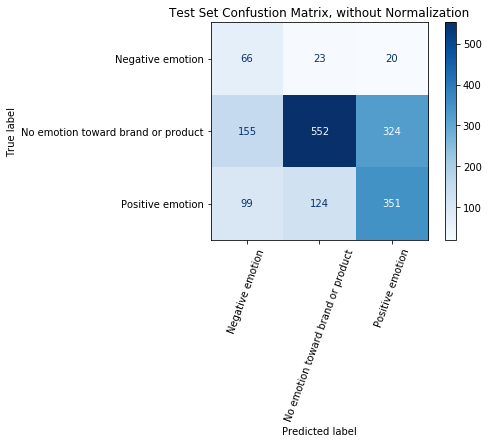

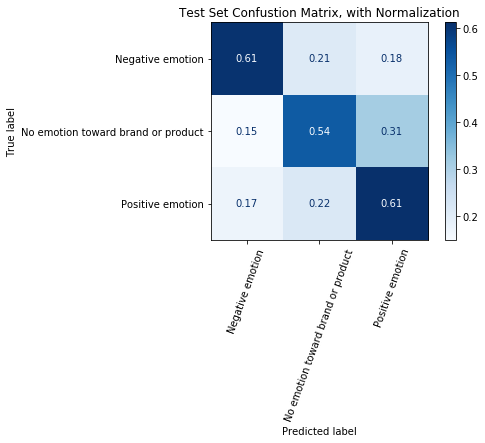

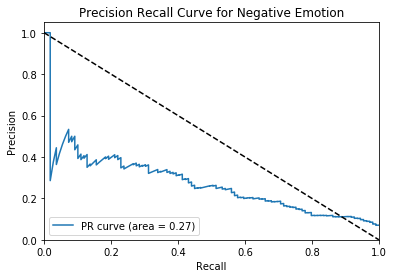

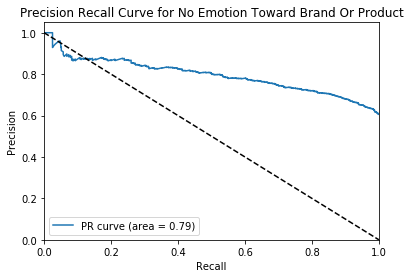

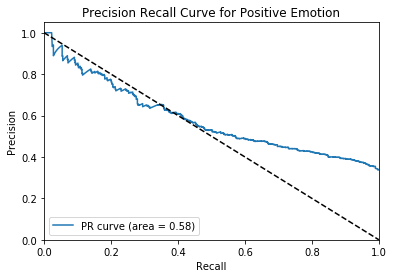

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 9

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.29      0.87      0.44       436
No emotion toward brand or product       0.84      0.60      0.70      4124
                  Positive emotion       0.59      0.67      0.62      2295

                          accuracy                           0.64      6855
                         macro avg       0.57      0.71      0.59      6855
                      weighted avg       0.72      0.64      0.66      6855



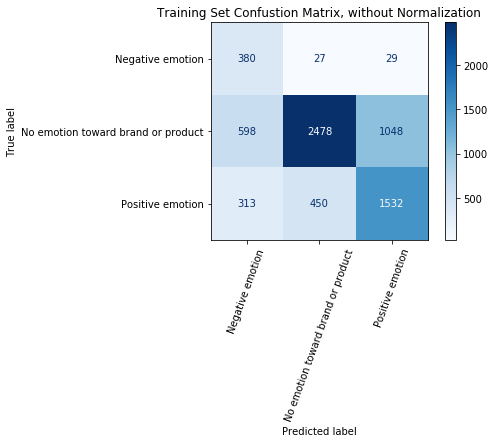

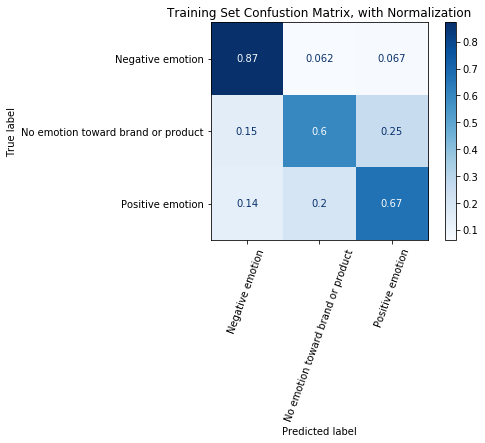

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.19      0.58      0.29       109
No emotion toward brand or product       0.78      0.53      0.63      1031
                  Positive emotion       0.50      0.60      0.55       574

                          accuracy                           0.56      1714
                         macro avg       0.49      0.57      0.49      1714
                      weighted avg       0.65      0.56      0.58      1714



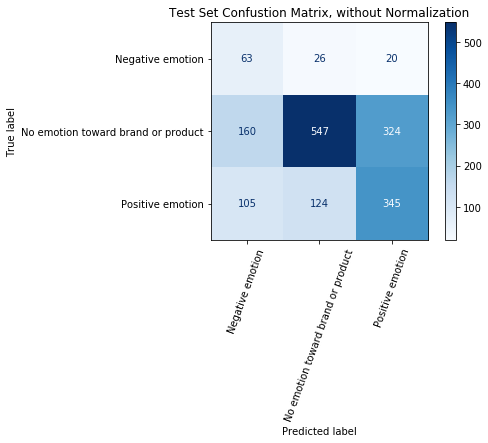

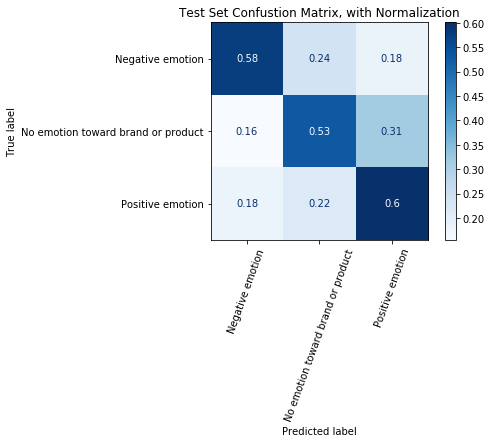

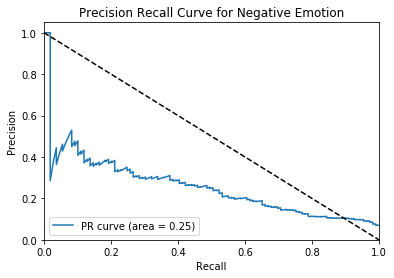

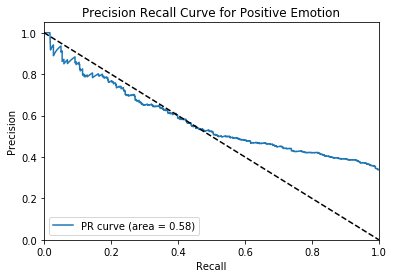

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 10

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.29      0.87      0.43       436
No emotion toward brand or product       0.84      0.59      0.69      4124
                  Positive emotion       0.59      0.67      0.62      2295

                          accuracy                           0.64      6855
                         macro avg       0.57      0.71      0.58      6855
                      weighted avg       0.72      0.64      0.65      6855



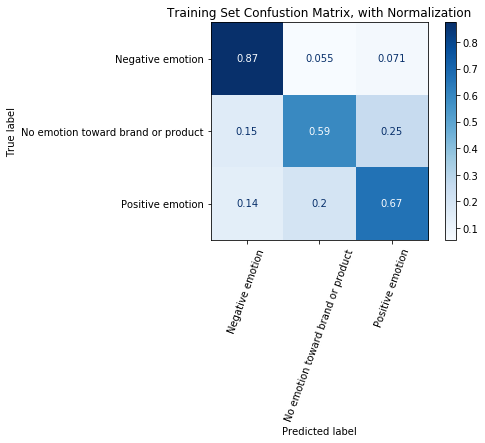

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.19      0.58      0.29       109
No emotion toward brand or product       0.79      0.53      0.64      1031
                  Positive emotion       0.51      0.61      0.55       574

                          accuracy                           0.56      1714
                         macro avg       0.50      0.57      0.49      1714
                      weighted avg       0.66      0.56      0.59      1714



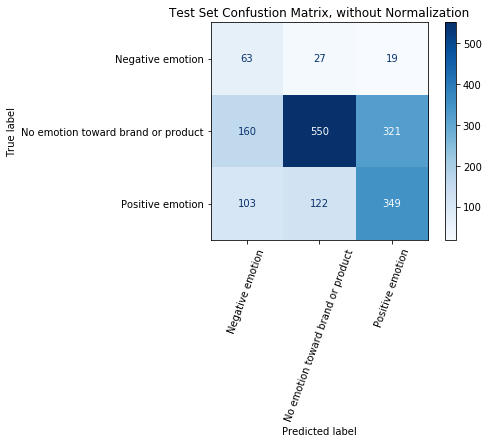

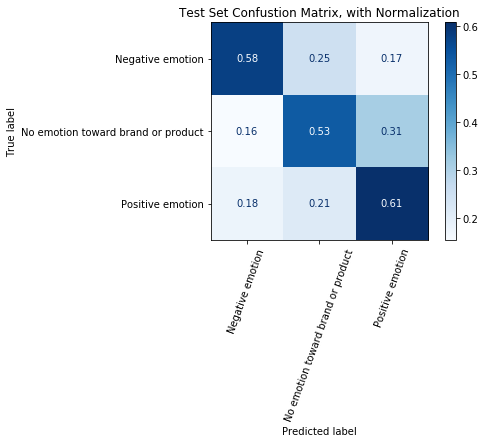

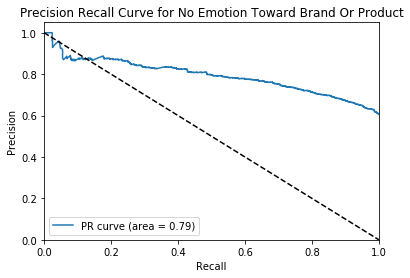

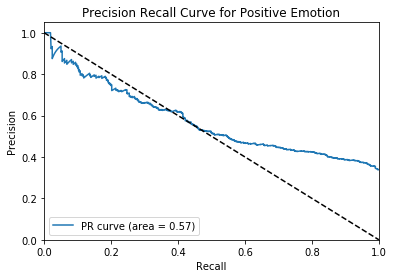

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 11

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.28      0.86      0.42       436
No emotion toward brand or product       0.83      0.59      0.69      4124
                  Positive emotion       0.58      0.66      0.62      2295

                          accuracy                           0.63      6855
                         macro avg       0.57      0.70      0.58      6855
                      weighted avg       0.71      0.63      0.65      6855



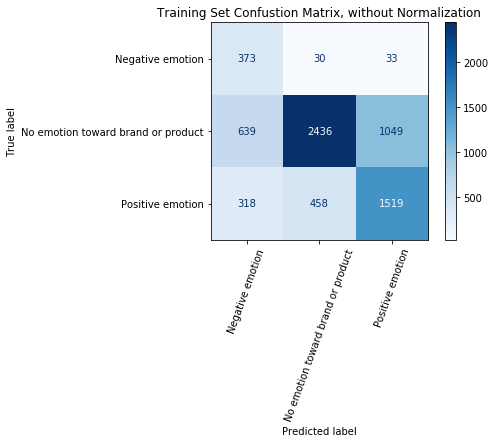

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.18      0.57      0.28       109
No emotion toward brand or product       0.78      0.53      0.63      1031
                  Positive emotion       0.49      0.59      0.54       574

                          accuracy                           0.55      1714
                         macro avg       0.49      0.56      0.48      1714
                      weighted avg       0.65      0.55      0.57      1714



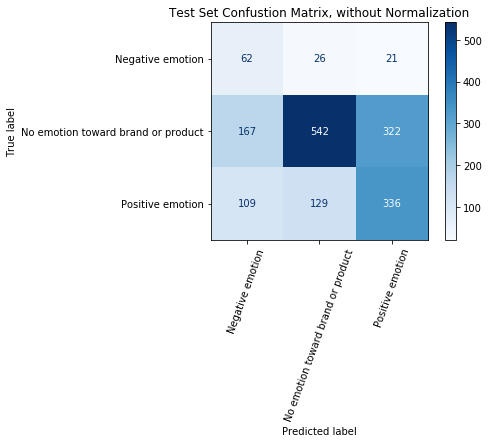

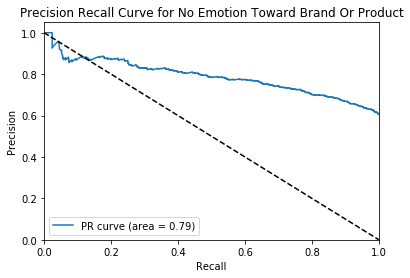

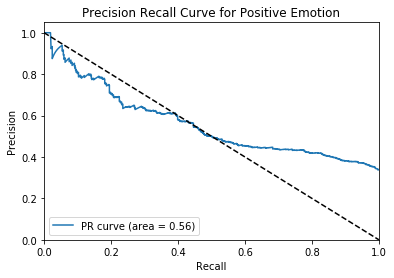

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 12

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.28      0.85      0.42       436
No emotion toward brand or product       0.83      0.58      0.69      4124
                  Positive emotion       0.58      0.65      0.61      2295

                          accuracy                           0.62      6855
                         macro avg       0.56      0.70      0.57      6855
                      weighted avg       0.71      0.62      0.64      6855



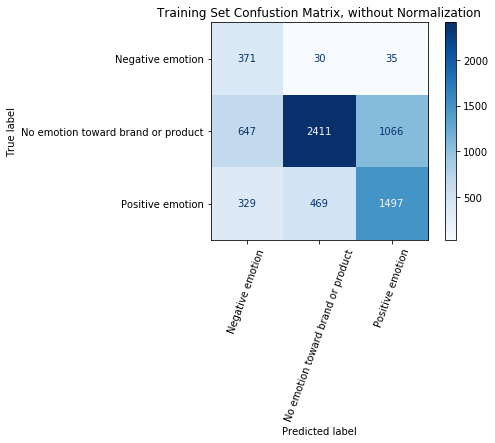

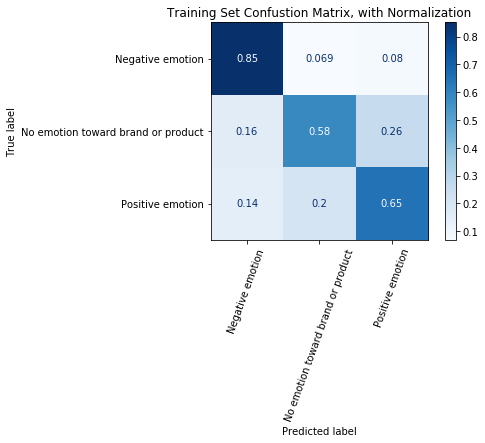

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.18      0.56      0.27       109
No emotion toward brand or product       0.77      0.52      0.62      1031
                  Positive emotion       0.49      0.58      0.53       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.55      0.48      1714
                      weighted avg       0.64      0.54      0.57      1714



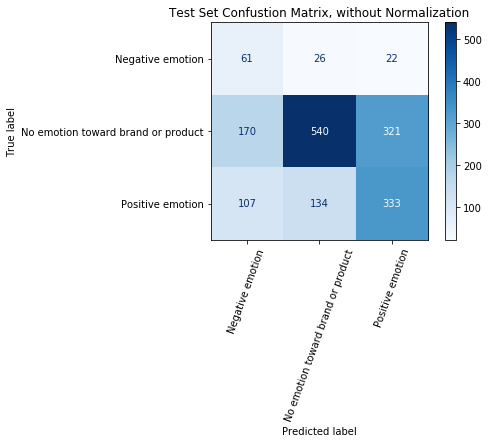

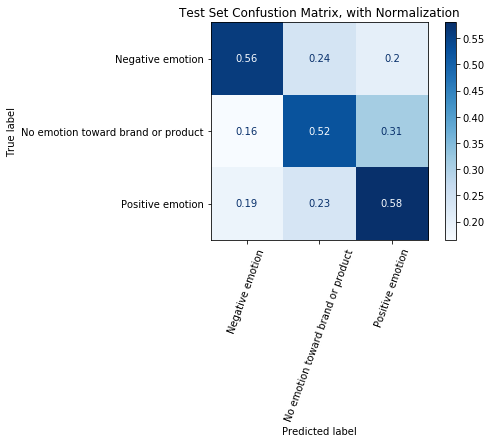

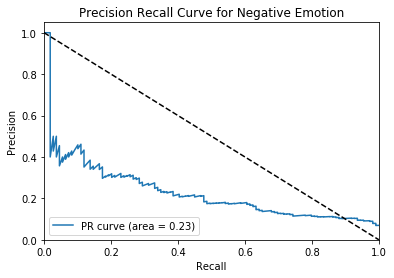

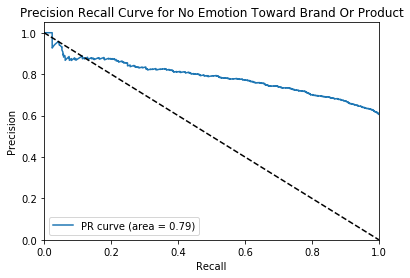

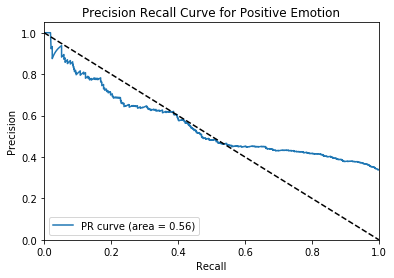

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 13

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.27      0.84      0.41       436
No emotion toward brand or product       0.83      0.59      0.69      4124
                  Positive emotion       0.57      0.65      0.61      2295

                          accuracy                           0.62      6855
                         macro avg       0.56      0.69      0.57      6855
                      weighted avg       0.71      0.62      0.64      6855



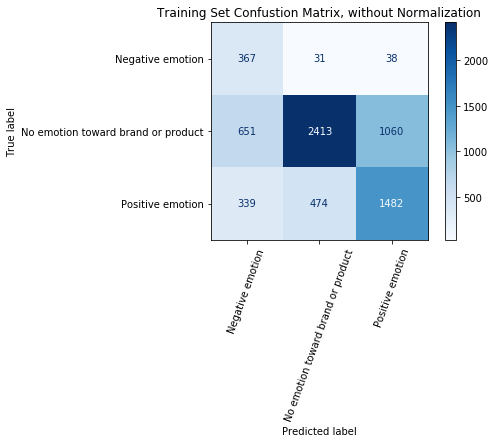

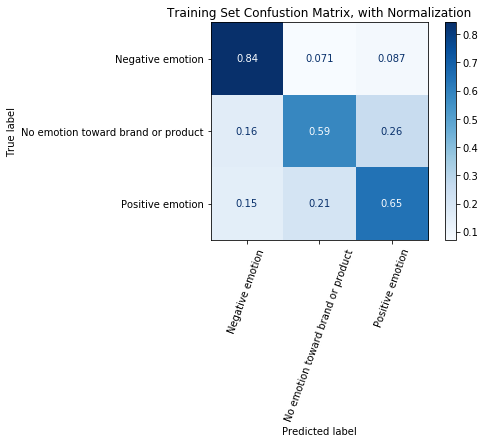

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.53      0.26       109
No emotion toward brand or product       0.77      0.52      0.62      1031
                  Positive emotion       0.49      0.58      0.53       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.47      1714
                      weighted avg       0.64      0.54      0.57      1714



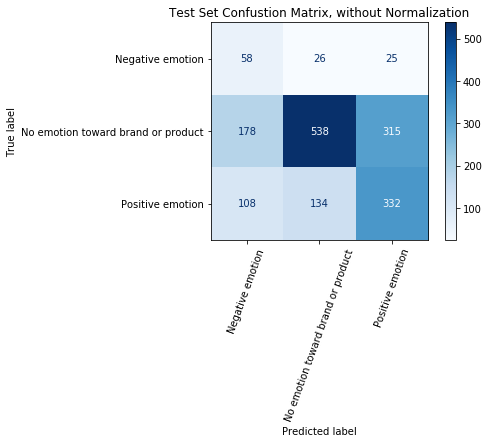

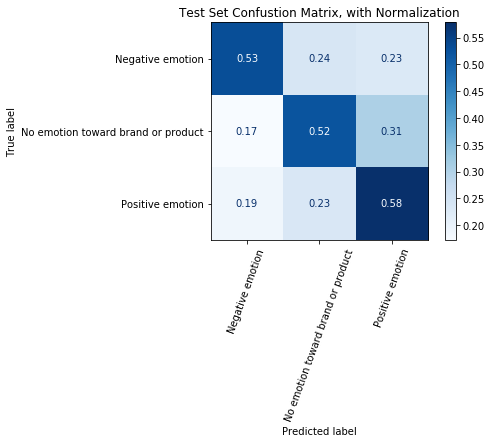

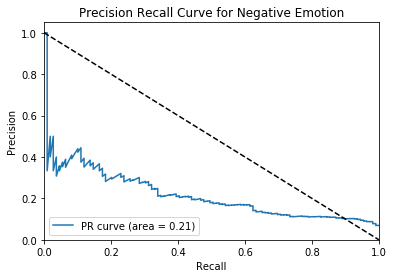

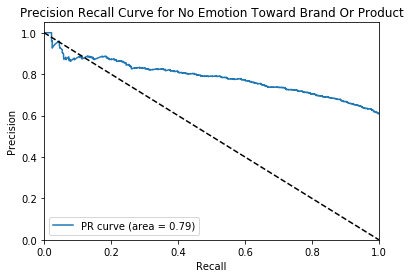

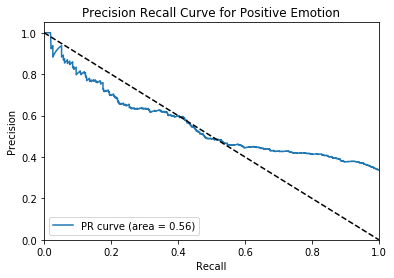

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 14

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.26      0.83      0.40       436
No emotion toward brand or product       0.82      0.58      0.68      4124
                  Positive emotion       0.57      0.64      0.60      2295

                          accuracy                           0.61      6855
                         macro avg       0.55      0.68      0.56      6855
                      weighted avg       0.70      0.61      0.63      6855



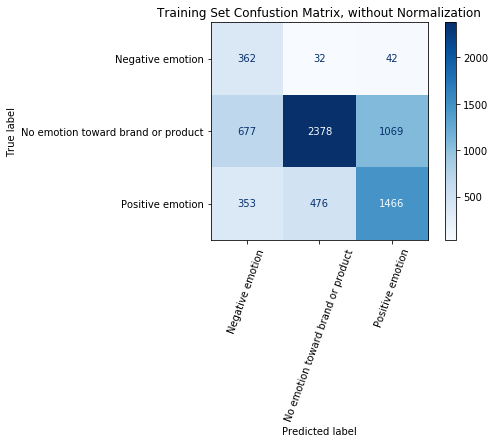

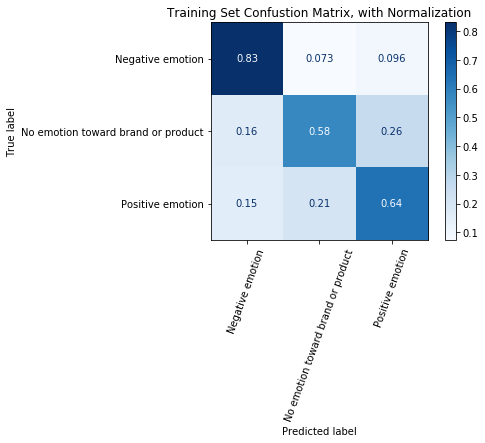

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.53      0.25       109
No emotion toward brand or product       0.78      0.52      0.62      1031
                  Positive emotion       0.49      0.58      0.53       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.47      1714
                      weighted avg       0.65      0.54      0.57      1714



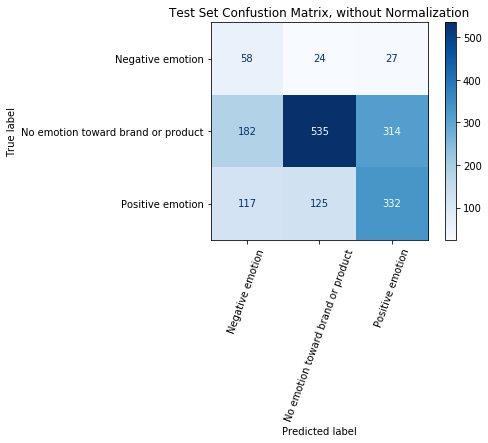

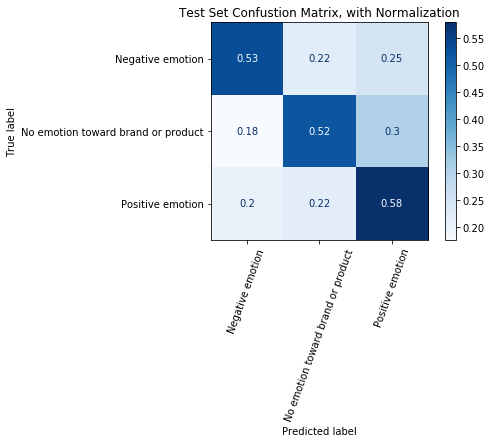

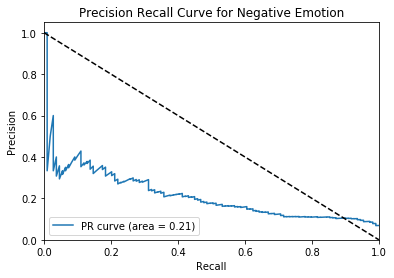

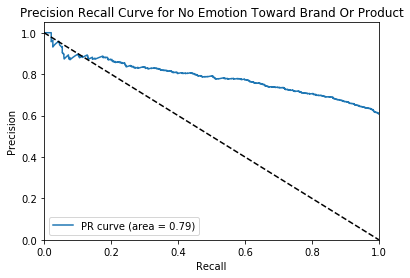

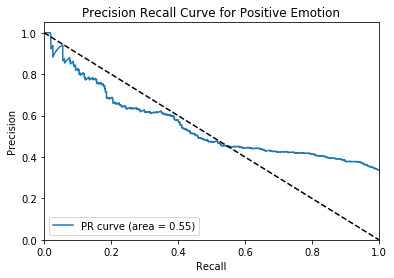

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 15

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.26      0.83      0.39       436
No emotion toward brand or product       0.82      0.58      0.68      4124
                  Positive emotion       0.57      0.64      0.60      2295

                          accuracy                           0.61      6855
                         macro avg       0.55      0.68      0.56      6855
                      weighted avg       0.70      0.61      0.64      6855



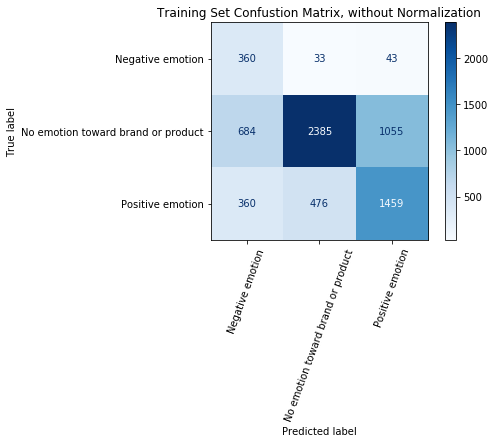

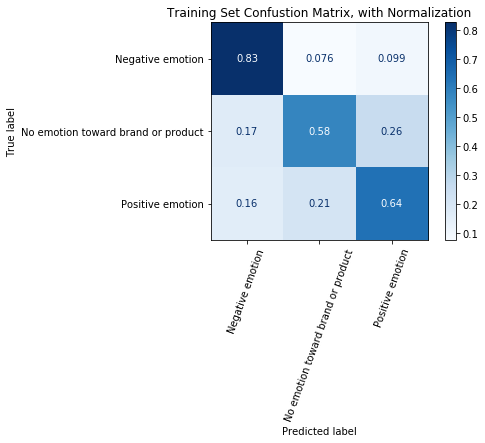

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.51      0.24       109
No emotion toward brand or product       0.78      0.51      0.62      1031
                  Positive emotion       0.49      0.58      0.53       574

                          accuracy                           0.54      1714
                         macro avg       0.47      0.53      0.46      1714
                      weighted avg       0.64      0.54      0.56      1714



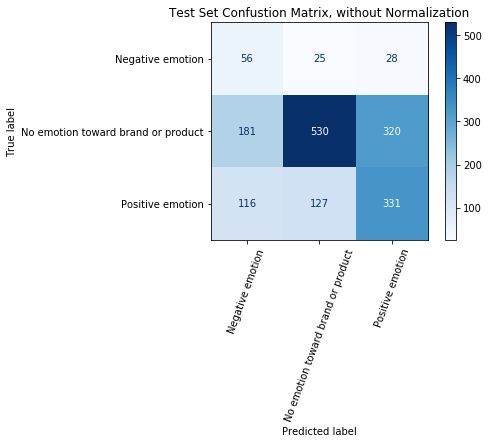

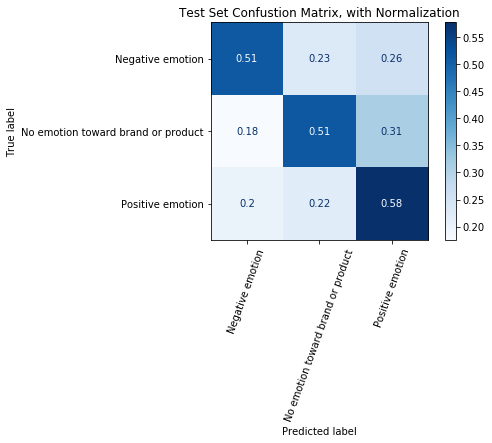

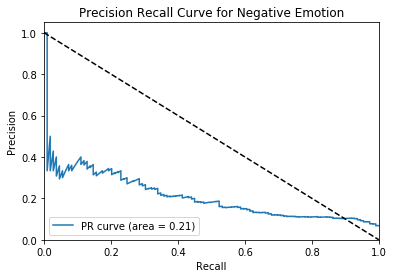

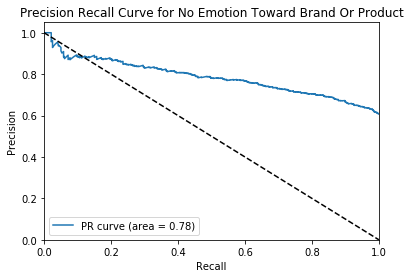

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 16

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.83      0.39       436
No emotion toward brand or product       0.82      0.57      0.67      4124
                  Positive emotion       0.56      0.63      0.59      2295

                          accuracy                           0.61      6855
                         macro avg       0.55      0.67      0.55      6855
                      weighted avg       0.70      0.61      0.63      6855



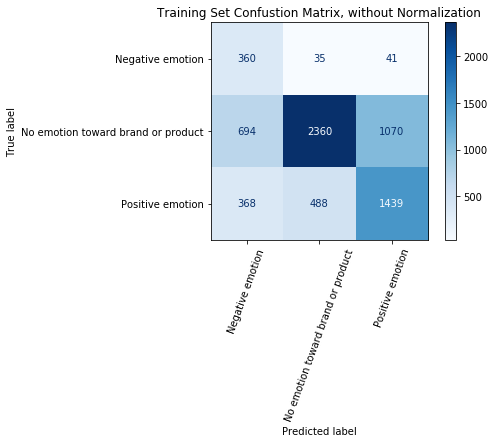

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.50      0.23       109
No emotion toward brand or product       0.78      0.52      0.62      1031
                  Positive emotion       0.49      0.57      0.52       574

                          accuracy                           0.53      1714
                         macro avg       0.47      0.53      0.46      1714
                      weighted avg       0.64      0.53      0.56      1714



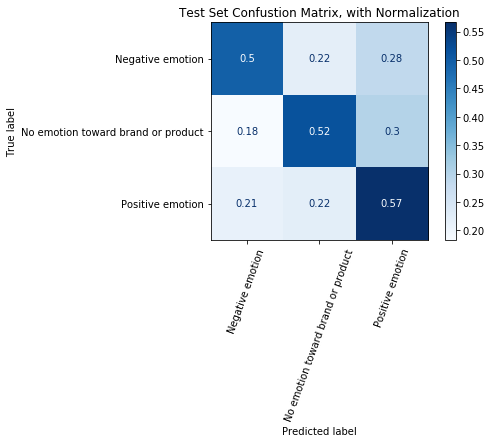

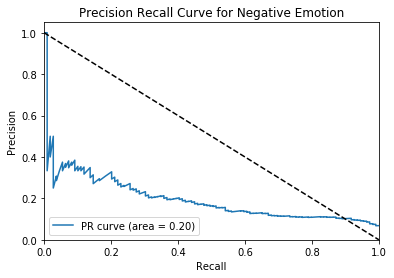

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 17

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.82      0.38       436
No emotion toward brand or product       0.82      0.57      0.68      4124
                  Positive emotion       0.56      0.62      0.59      2295

                          accuracy                           0.61      6855
                         macro avg       0.54      0.67      0.55      6855
                      weighted avg       0.70      0.61      0.63      6855



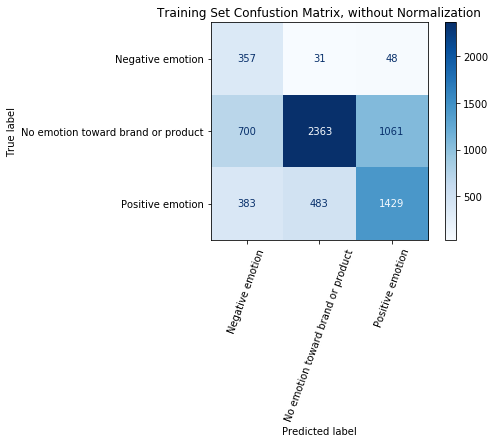

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.14      0.49      0.22       109
No emotion toward brand or product       0.78      0.52      0.62      1031
                  Positive emotion       0.48      0.56      0.52       574

                          accuracy                           0.53      1714
                         macro avg       0.47      0.52      0.45      1714
                      weighted avg       0.64      0.53      0.56      1714



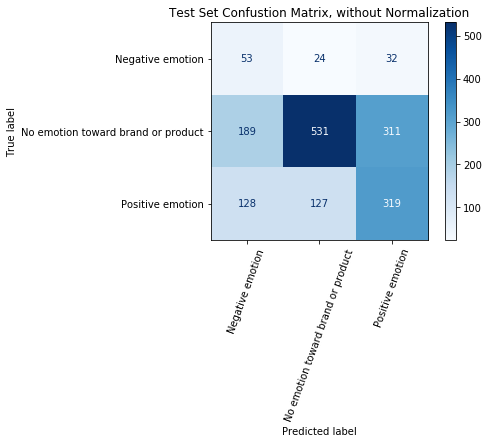

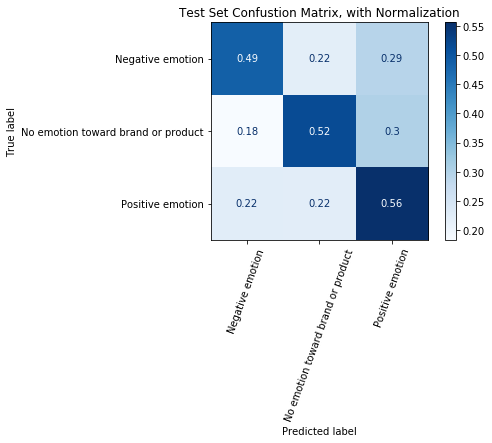

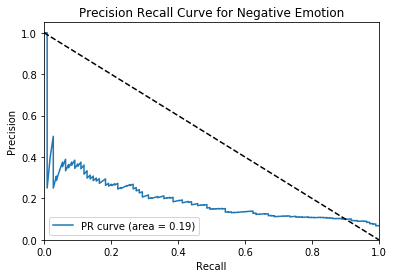

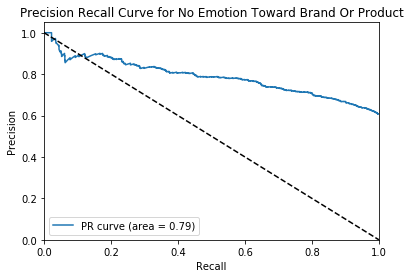

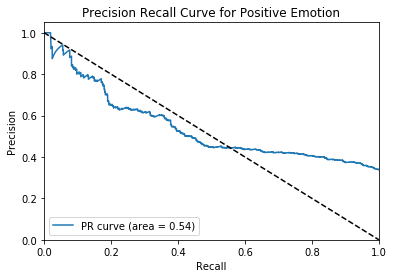

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 18

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.82      0.38       436
No emotion toward brand or product       0.82      0.57      0.67      4124
                  Positive emotion       0.56      0.62      0.59      2295

                          accuracy                           0.60      6855
                         macro avg       0.54      0.67      0.55      6855
                      weighted avg       0.70      0.60      0.63      6855



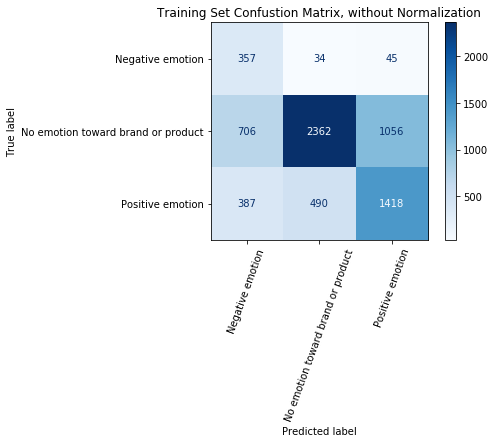

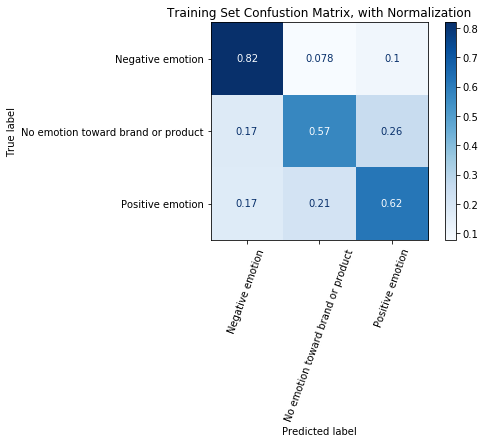

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.50      0.23       109
No emotion toward brand or product       0.79      0.53      0.63      1031
                  Positive emotion       0.49      0.56      0.52       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.53      0.46      1714
                      weighted avg       0.65      0.54      0.57      1714



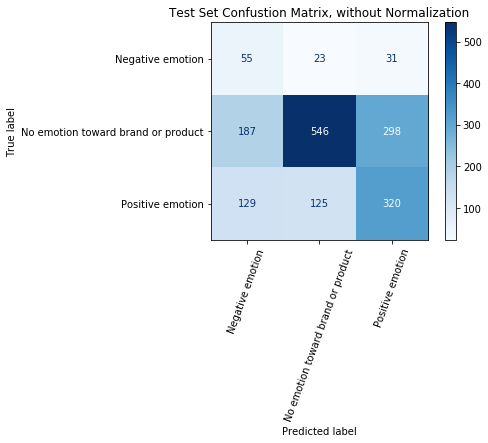

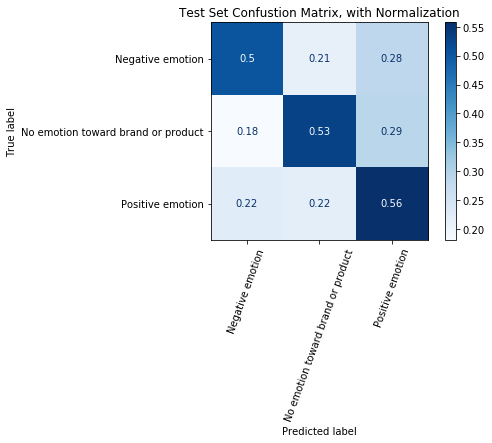

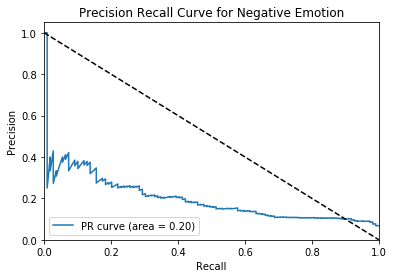

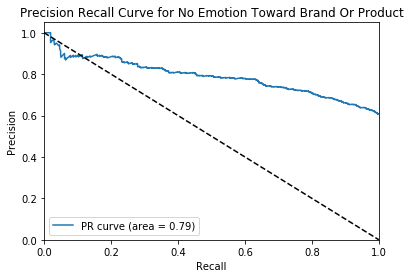

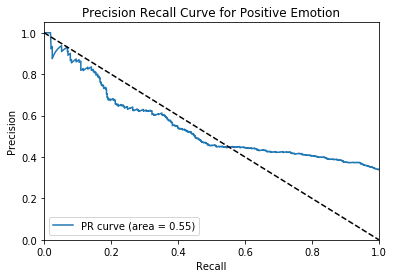

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 19

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.81      0.37       436
No emotion toward brand or product       0.82      0.57      0.67      4124
                  Positive emotion       0.56      0.61      0.58      2295

                          accuracy                           0.60      6855
                         macro avg       0.54      0.67      0.54      6855
                      weighted avg       0.69      0.60      0.62      6855



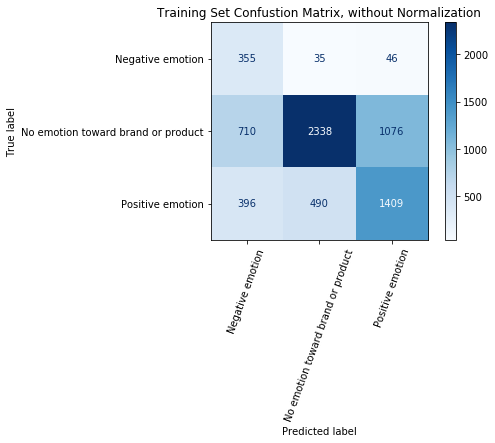

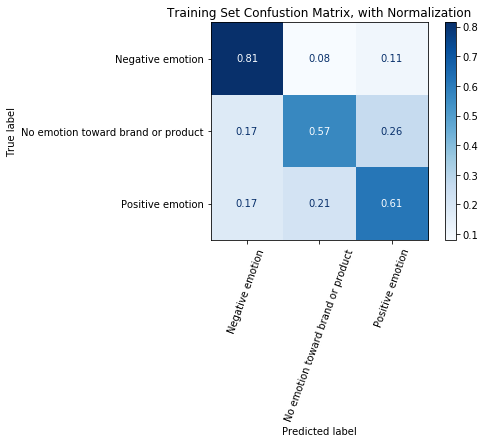

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.51      0.23       109
No emotion toward brand or product       0.79      0.53      0.63      1031
                  Positive emotion       0.50      0.57      0.53       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.65      0.54      0.57      1714



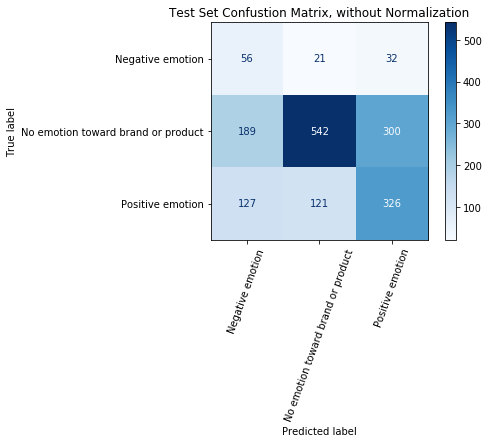

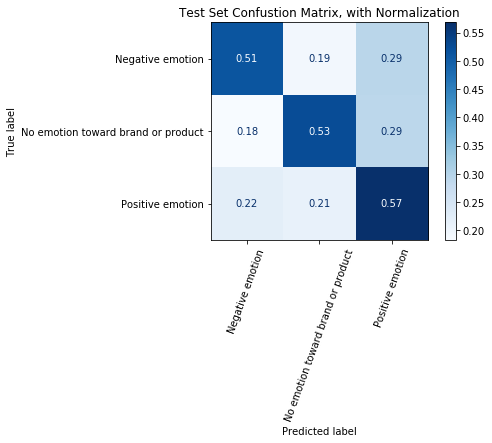

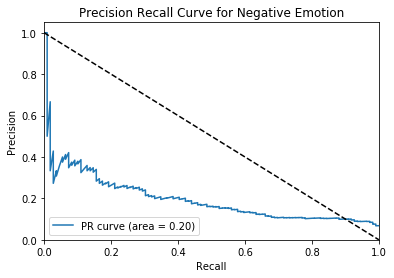

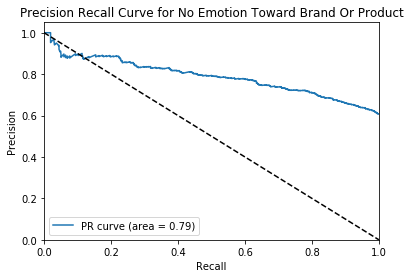

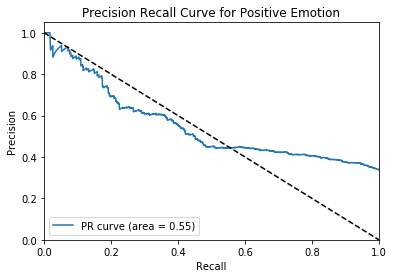

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 20

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.82      0.37       436
No emotion toward brand or product       0.82      0.56      0.67      4124
                  Positive emotion       0.55      0.61      0.58      2295

                          accuracy                           0.59      6855
                         macro avg       0.54      0.66      0.54      6855
                      weighted avg       0.69      0.59      0.62      6855



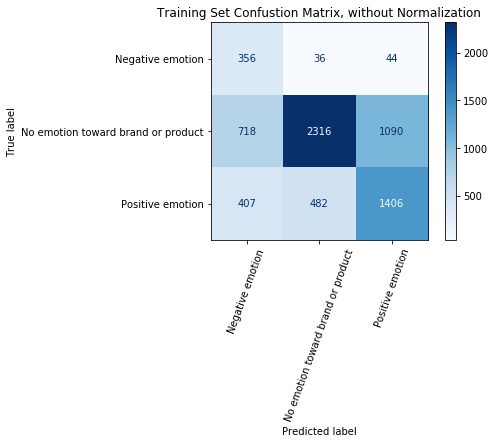

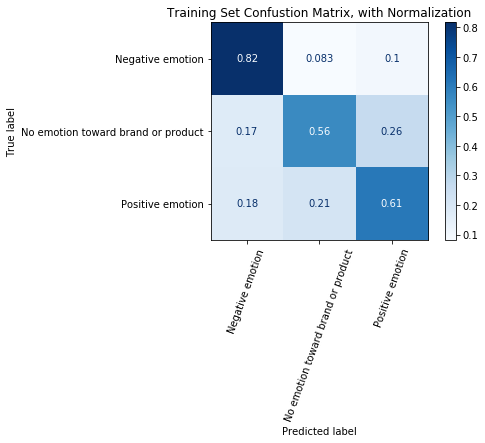

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.51      0.23       109
No emotion toward brand or product       0.79      0.52      0.63      1031
                  Positive emotion       0.49      0.56      0.53       574

                          accuracy                           0.53      1714
                         macro avg       0.48      0.53      0.46      1714
                      weighted avg       0.65      0.53      0.57      1714



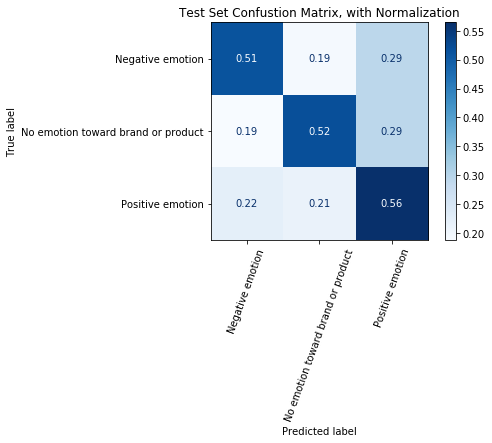

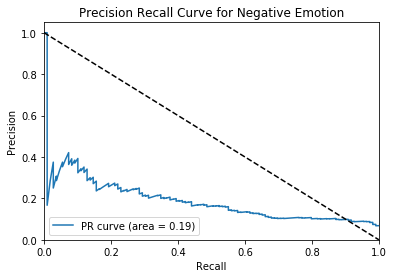

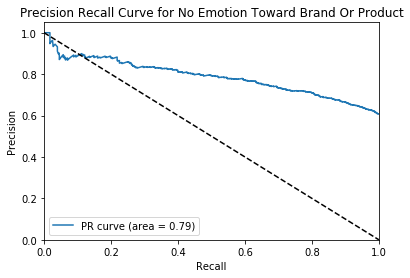

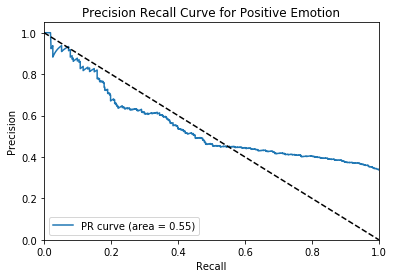

In [16]:
metrics_summary = []

for min_df in range(1,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

In [17]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'train accuracy',
                                           'test accuracy',
                                          'neg recall',
                                          'neutral recall',
                                          'pos recall'])

metrics_summary_df

min doc freq  train accuracy  test accuracy  neg recall  neutral recall  \
0            1.0        0.772137       0.596266    0.596330        0.559651   
1            2.0        0.737272       0.592182    0.596330        0.554801   
2            3.0        0.713786       0.587515    0.596330        0.555771   
3            4.0        0.692487       0.581680    0.596330        0.548012   
4            5.0        0.683735       0.589265    0.596330        0.557711   
5            6.0        0.674544       0.572929    0.596330        0.541222   
6            7.0        0.660832       0.571179    0.623853        0.538312   
7            8.0        0.650766       0.565344    0.605505        0.535403   
8            9.0        0.640408       0.557176    0.577982        0.530553   
9           10.0        0.635886       0.561260    0.577982        0.533463   
10          11.0        0.631364       0.548425    0.568807        0.525703   
11          12.0        0.624216       0.544924    0.559633        0.523763   
12          13.0        0.621736       0.541424    0.532110        0.521823   
13          14.0        0.613567       0.539673    0.532110        0.518914   
14          15.0        0.613275       0.535006    0.513761        0.514064   
15          16.0        0.606710       0.531505    0.495413        0.516004   
16          17.0        0.605252       0.526838    0.486239        0.515034   
17          18.0        0.603501       0.537340    0.504587        0.529583   
18          19.0        0.598395       0.539090    0.513761        0.525703   
19          20.0        0.594894       0.533839    0.513761        0.518914   

    pos recall  
0     0.662021  
1     0.658537  
2     0.642857  
3     0.639373  
4     0.644599  
5     0.625436  
6     0.620209  
7     0.611498  
8     0.601045  
9     0.608014  
10    0.585366  
11    0.580139  
12    0.578397  
13    0.578397  
14    0.576655  
15    0.566202  
16    0.555749  
17    0.557491  
18    0.567944  
19    0.564460

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 0

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.47      0.97      0.64       436
No emotion toward brand or product       0.92      0.71      0.81      4124
                  Positive emotion       0.70      0.84      0.76      2295

                          accuracy                           0.77      6855
                         macro avg       0.70      0.84      0.73      6855
                      weighted avg       0.82      0.77      0.78      6855



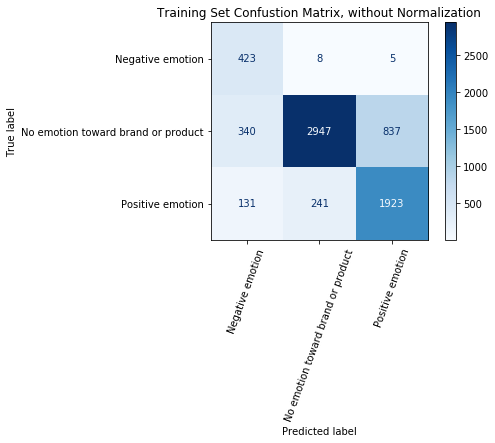

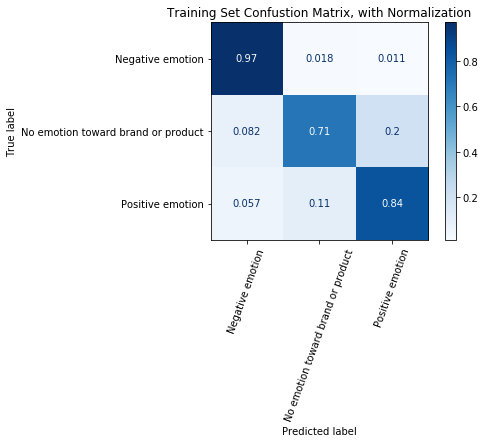

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.60      0.36       109
No emotion toward brand or product       0.79      0.56      0.65      1031
                  Positive emotion       0.52      0.66      0.58       574

                          accuracy                           0.60      1714
                         macro avg       0.52      0.61      0.53      1714
                      weighted avg       0.67      0.60      0.61      1714



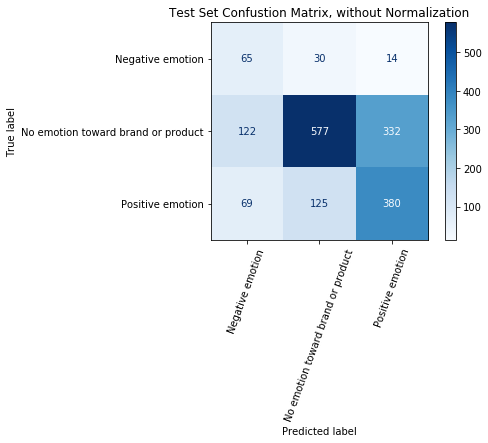

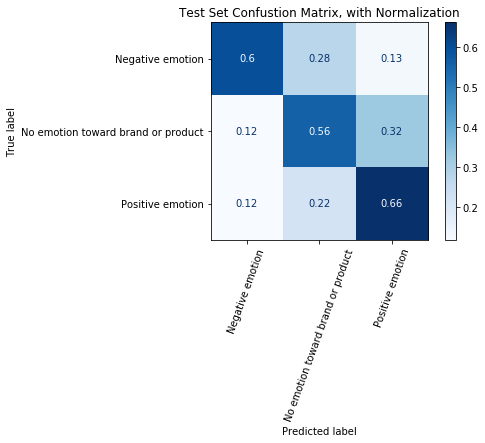

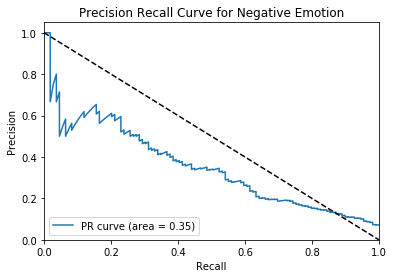

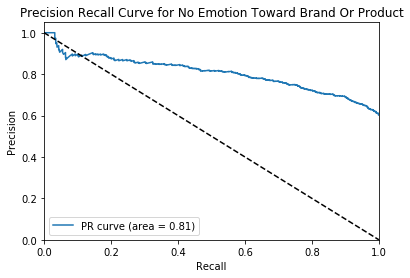

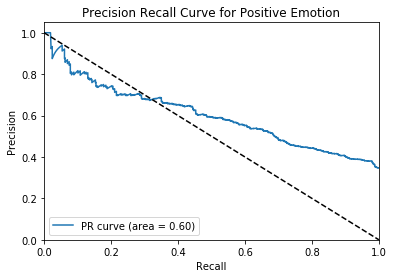

In [18]:
metrics = train_and_eval_model(min_df=0)

# Summary

The addition of SMOTE oversampling provided a significant increase in model performance.

The Recall values for each of the classes are near even at 0.60, 0.56, and 0.66 for Negative, Neutral and Positive respectively, which gave a macro average recall of 0.61.

Overall accuracy went down to 0.60, because the recall for Neutral, the majority class, went down.  A lower overall accuracy is better in this case because the recall scores for the minority classes saw a significant increase.